In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sun Aug 20 05:24:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    63W / 300W |  21543MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 80
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256, dilation_rate=3)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train08.20-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 140000, model, None, optimizer)

total 0


### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    

test : 0 1.135026216506958
test : 1 1.1364917755126953
test : 2 1.1346619129180908
test : 3 1.1360085010528564
test : 4 1.135246992111206
test : 5 1.1380586624145508
test : 6 1.1425820589065552
test : 7 1.1392043828964233
test : 8 1.136634349822998
test : 9 1.134355902671814
test_loss : 1.1368271112442017


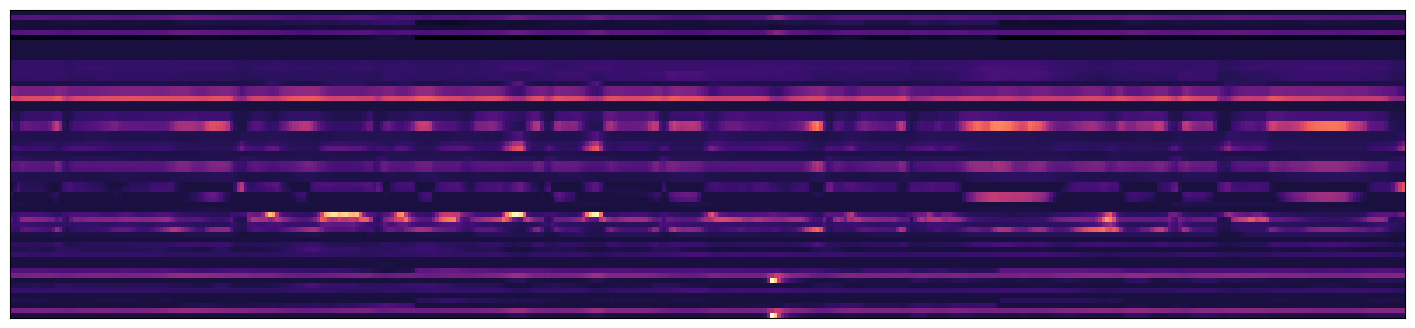

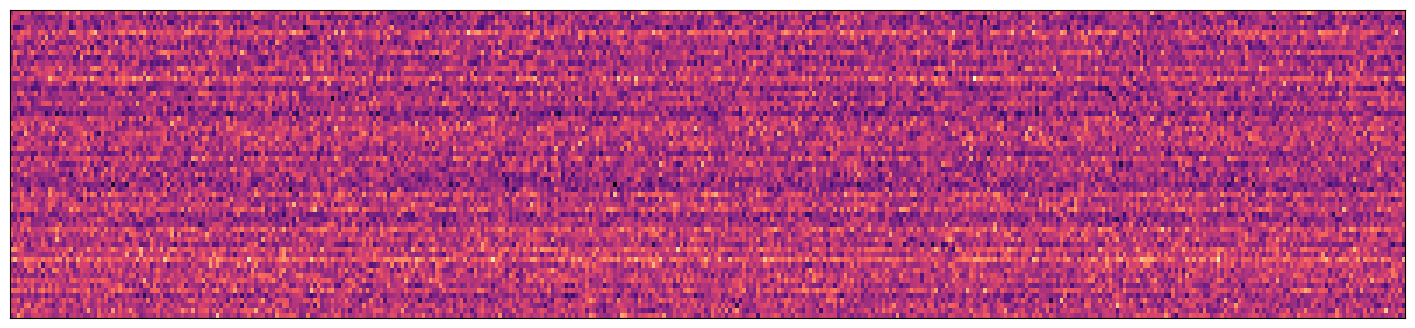

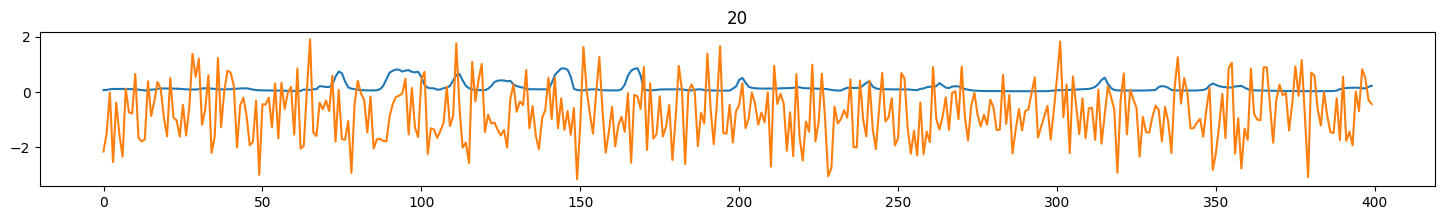

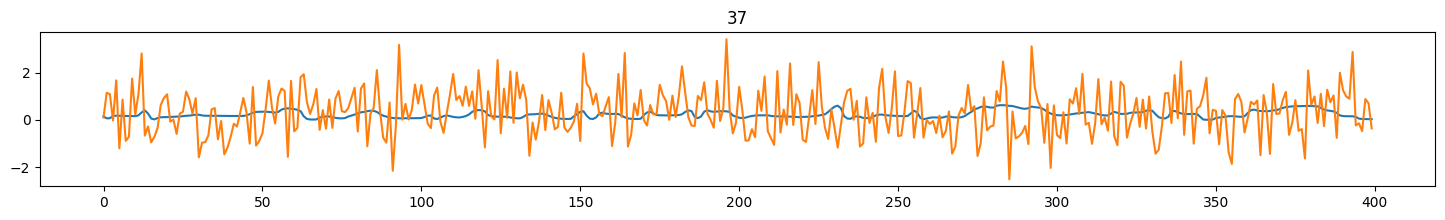

saved /data/scpark/save/lips/train08.20-1/save_0
1
loss 1.1488476991653442
1 1.1488476991653442
2
loss 1.0454485416412354
2 1.0454485416412354
3
loss 0.9562279582023621
3 0.9562279582023621
4
loss 0.8675347566604614
4 0.8675347566604614
5
loss 0.7902372479438782
5 0.7902372479438782
6
loss 0.7192559242248535
6 0.7192559242248535
7
loss 0.6416916847229004
7 0.6416916847229004
8
loss 0.5647578239440918
8 0.5647578239440918
9
loss 0.49955615401268005
9 0.49955615401268005
10
loss 0.4275764524936676
10 0.4275764524936676
11
loss 0.35694700479507446
11 0.35694700479507446
12
loss 0.302920401096344
12 0.302920401096344
13
loss 0.2412627935409546
13 0.2412627935409546
14
loss 0.18320977687835693
14 0.18320977687835693
15
loss 0.13786691427230835
15 0.13786691427230835
16
loss 0.08331263065338135
16 0.08331263065338135
17
loss 0.04123508930206299
17 0.04123508930206299
18
loss -0.0057566165924072266
18 -0.0057566165924072266


In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = get_mel(torch.Tensor(batch['wav'])).to(device)
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)